# 1. Introduction
Author: Itai Shapira, May 2023

Here we present and analyze the results of our experiments. The purpose of this notebook is to provide a clear and comprehensive view of the experimental data, enabling us to visualize and understand the implications of our findings.

Throughout this notebook, we will load the experimental data from disk and generate a series of plots to visualize various aspects of our results. Some of the key plots include:


## 1.1 Load Data

In [2]:
# connect to google drive:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

sns.set_style("ticks")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12


# Set font sizes and style
title_fontsize = 20
label_fontsize = 18
tick_fontsize = 14

# Set line width and marker size
linewidth = 3.5
markersize = 15
# Set default font sizes and style
plt.rcParams['axes.titlesize'] = title_fontsize
plt.rcParams['axes.labelsize'] = label_fontsize
plt.rcParams['xtick.labelsize'] = tick_fontsize
plt.rcParams['ytick.labelsize'] = tick_fontsize

# Set default line width and marker size
plt.rcParams['lines.linewidth'] = linewidth
plt.rcParams['lines.markersize'] = markersize


Mounted at /content/drive


In [3]:
def process_dataframe(df, train_data_points, batch_size):
  m = int(train_data_points / batch_size)

  # Step 0: Convert k1 and k2 to steps instead of epochs.
  df['k1'] *= m
  df['k2'] *= m

  # Step 1: Compute additional_steps, which is k2 - k1.
  df['additional_steps'] = df['k2'] - df['k1']

  # Helper function to convert strings representing lists to actual numpy arrays.
  def str_to_array(s):
    try:
      return np.array(eval(s), dtype=float)
    except:
      try:
        s = s.replace("\n","").replace("  ",",").replace(" ",',').replace("[,",'[').replace(",,",',')
        return str_to_array(s)
      except:
        return s

  # Step 2: Compute loss_barrier for train and test sets.
  df["losses_train"] = df["losses_train"].apply(str_to_array)
  df["losses_test"] = df["losses_test"].apply(str_to_array)
  df['loss_barrier_train'] = df['losses_train'].apply(lambda x: np.max((str_to_array(x))))
  df['loss_barrier_test'] = df['losses_test'].apply(lambda x: np.max((str_to_array(x))))

  # Step 3: Convert accuracy columns to numpy arrays, and change accuracy to error.
  df['accuracy_lst_train'] = df['accuracy_lst_train'].apply(str_to_array)
  df['accuracy_lst_test'] = df['accuracy_lst_test'].apply(str_to_array)
  df['error_lst_train'] = 1 - df['accuracy_lst_train']
  df['error_lst_test'] = 1 - df['accuracy_lst_test']

  # Step 4: Compute error_barrier for train and test sets.
  df['error_barrier_train'] = df['error_lst_train'].apply(lambda x: np.max(x))
  df['error_barrier_test'] = df['error_lst_test'].apply(lambda x: np.max(x))

  df['first_error_train'] = df['error_lst_train'].apply(lambda x: x[0])
  df['first_error_test'] = df['error_lst_test'].apply(lambda x: x[0])

  df['last_error_train'] = df['error_lst_train'].apply(lambda x: x[-1])
  df['last_error_test'] = df['error_lst_test'].apply(lambda x: x[-1])

  df['last_accuracy_train'] = df['accuracy_lst_train'].apply(lambda x: x[-1])
  df['last_accuracy_test'] = df['accuracy_lst_test'].apply(lambda x: x[-1])

  # Step 5: Compute normalized columns.
  def normalize_array(x, alpha):
      return x - ((1 - alpha) * x[0] + alpha * x[-1])

  alpha_values = np.linspace(0, 1, 25)

  df['norm_loss_train'] = df.apply(lambda row: normalize_array(str_to_array(row['losses_train']), alpha_values), axis=1)
  df['norm_loss_test'] = df.apply(lambda row: normalize_array(str_to_array(row['losses_test']), alpha_values), axis=1)
  df['norm_error_train'] = df.apply(lambda row: normalize_array(row['error_lst_train'], alpha_values), axis=1)
  df['norm_error_test'] = df.apply(lambda row: normalize_array(row['error_lst_test'], alpha_values), axis=1)


  df['norm_loss_barrier_train'] = df['norm_loss_train'].apply(lambda x: np.max((x)))
  df['norm_loss_barrier_test'] = df['norm_loss_test'].apply(lambda x: np.max((x)))
  df['norm_error_barrier_train'] = df['norm_error_train'].apply(lambda x: np.max(x))
  df['norm_error_barrier_test'] = df['norm_error_test'].apply(lambda x: np.max(x))
  return df

In [8]:
path = "/content/drive/MyDrive/Itais_drive/school/Harvard/courses/spring23/CS229br/project/linear_mode_connectivity"

dataset = "CIFAR-10"
df_cifar = pd.read_csv(f"{path}/experiments/dataframes/{dataset}_df.csv")
df_cifar = process_dataframe(df_cifar, 50000, batch_size = 128)

dataset = "MNIST"
df_mnist = pd.read_csv(f"{path}/experiments/dataframes/{dataset}_df.csv")
df_mnist = process_dataframe(df_mnist, 60000, batch_size = 1024)

dataset = "TINYIMAGENET"
df_tinyimagenet = pd.read_csv(f"{path}/experiments/dataframes/{dataset}_df.csv")
df_tinyimagenet = process_dataframe(df_tinyimagenet, 100000, batch_size = 64)

# 2. Plot

In [9]:
# Assuming df_mnist, df_cifar, and df_tinyimagenet are already defined
dfs = [df_tinyimagenet, df_cifar, df_mnist]
titles = ['Tiny-ImageNet', 'CIFAR-10', 'MNIST']
palette = sns.color_palette("viridis", n_colors=2)



# Create the directory if it doesn't exist
if not os.path.exists("./plots/barrier_k1/"):
    os.makedirs("./plots/barrier_k1/")

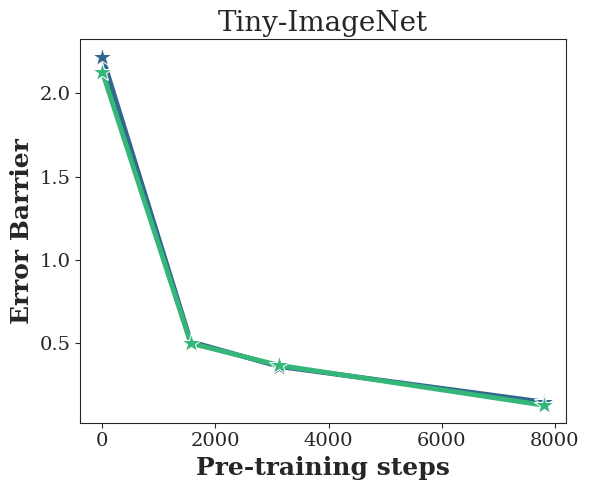

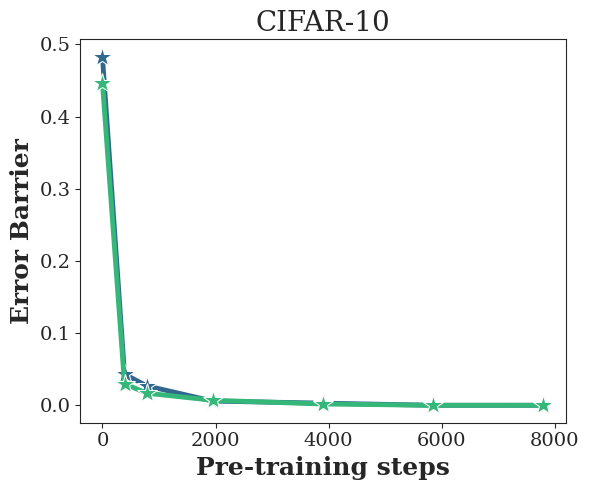

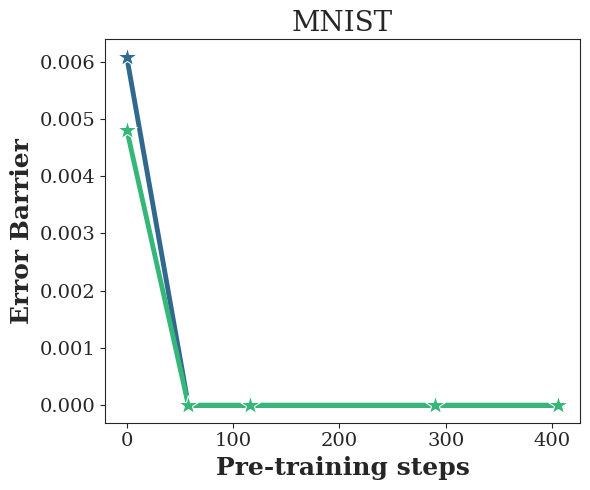

In [5]:
import matplotlib.patches as mpatches


titles = ['Tiny-ImageNet', 'CIFAR-10', 'MNIST']

palette = sns.color_palette("viridis", n_colors=2)
legend_patches = []

for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(6, 5))

    max_k2_per_k1 = df.groupby('k1')['k2'].max().reset_index()
    filtered_df = pd.merge(df, max_k2_per_k1, on=['k1', 'k2'])

    sns.lineplot(data=filtered_df, x='k1', y='norm_loss_barrier_train', marker='*', color=palette[0], ax=ax)
    sns.lineplot(data=filtered_df, x='k1', y='norm_loss_barrier_test', marker='*',  color=palette[1], ax=ax)

    ax.set_xlabel('Pre-training steps', fontsize=label_fontsize)
    ax.set_ylabel('Error Barrier', fontsize=label_fontsize)
    ax.set_title(f'{titles[i]}', fontsize=title_fontsize)

    #ax.set_ylim(y_min, y_max)

    fig.tight_layout()
    plt.savefig(f"./plots/barrier_k1/plot_{i+1}_{titles[i].replace('-', '_')}_error_barrier.pdf")
    plt.show()
    plt.close(fig)

    # Create and store legend patches only once
    if i == 0:
        legend_patches = [
            mpatches.Patch(color=palette[0], label="Train"),
            mpatches.Patch(color=palette[1], label="Test"),
        ]

# Save the legend separately as a PDF
fig, ax = plt.subplots(figsize=(1, 1))
ax.legend(handles=legend_patches, loc='center')
ax.axis('off')
fig.tight_layout()
plt.savefig(f"./plots/barrier_k1/legend_error_barrier.pdf")
plt.close(fig)


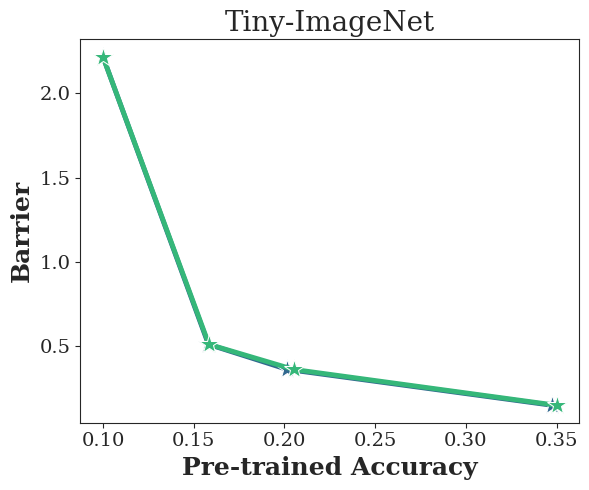

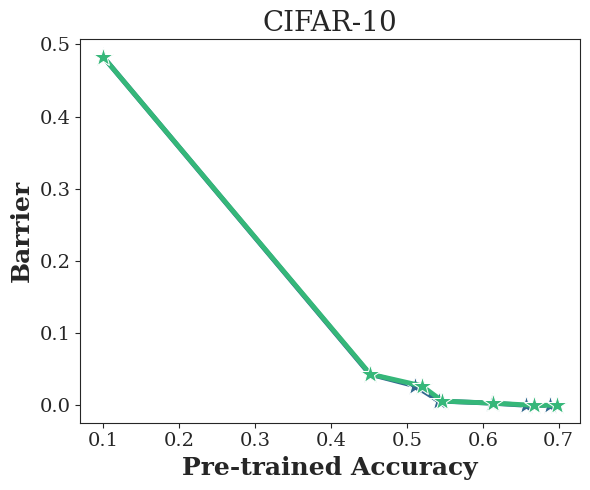

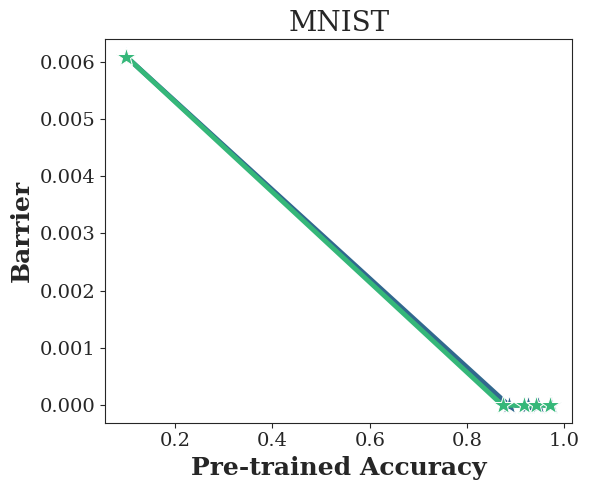

In [6]:
# Second 3 plots
for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(6, 5))

    unique_k1_values = df['k1'].unique()
    first_accuracy_values = [0.1]
    train_accuracy_values = [0.1]
    barrier_values = []

    for k1_value in unique_k1_values:
        max_k2 = df[df['k1'] == k1_value]['k2'].max()
        barrier = df[(df['k1'] == k1_value) & (df['k2'] == max_k2)]['norm_loss_barrier_train'].iloc[0]
        barrier_values.append(barrier)

        min_k2 = df[(df['k2'] >= k1_value) & (df["k1"] == k1_value)]['k2'].min()
        first_accuracy = df[(df['k1'] == k1_value) & (df['k2'] == min_k2)]['last_accuracy_test'].iloc[0]
        first_accuracy_values.append(first_accuracy)
        train_accuracy = df[(df['k1'] == k1_value) & (df['k2'] == min_k2)]['last_accuracy_train'].iloc[0]
        train_accuracy_values.append(train_accuracy)

    sns.lineplot(x=first_accuracy_values[:-1], y=barrier_values, marker='*',  color=palette[0], ax=ax)
    sns.lineplot(x=train_accuracy_values[:-1], y=barrier_values, marker='*',  color=palette[1], ax=ax)
    

    ax.set_xlabel('Pre-trained Accuracy', fontsize=label_fontsize)
    ax.set_ylabel('Barrier', fontsize=label_fontsize)
    ax.set_title(f'{titles[i]}', fontsize=title_fontsize)


    # Create and store legend patches only once
    if i == 0:
        legend_patches = [
            mpatches.Patch(color=palette[0], label="Train"),
            mpatches.Patch(color=palette[1], label="Test"),
        ]
    fig.tight_layout()
    plt.savefig(f"./plots/barrier_k1/plot_{i+4}_{titles[i].replace('-', '_')}_barrier.pdf")




## 2.2 Barrier For Different values of (k1, k2)

In [7]:
# Create the directory if it doesn't exist
if not os.path.exists("./plots/linear_path/"):
    os.makedirs("./plots/linear_path/")

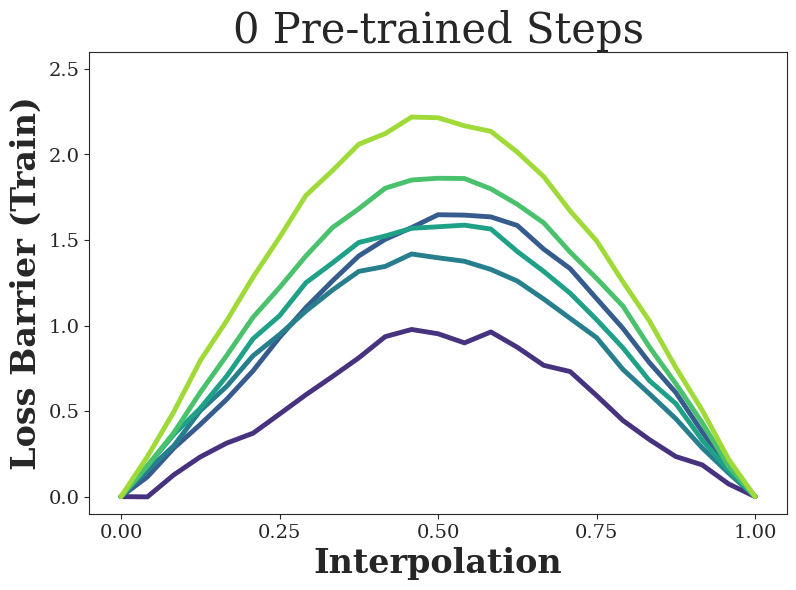

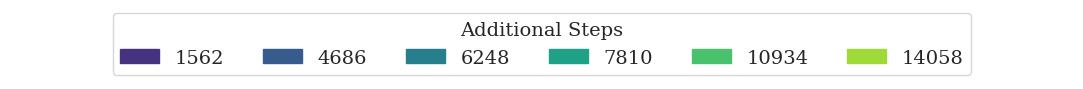

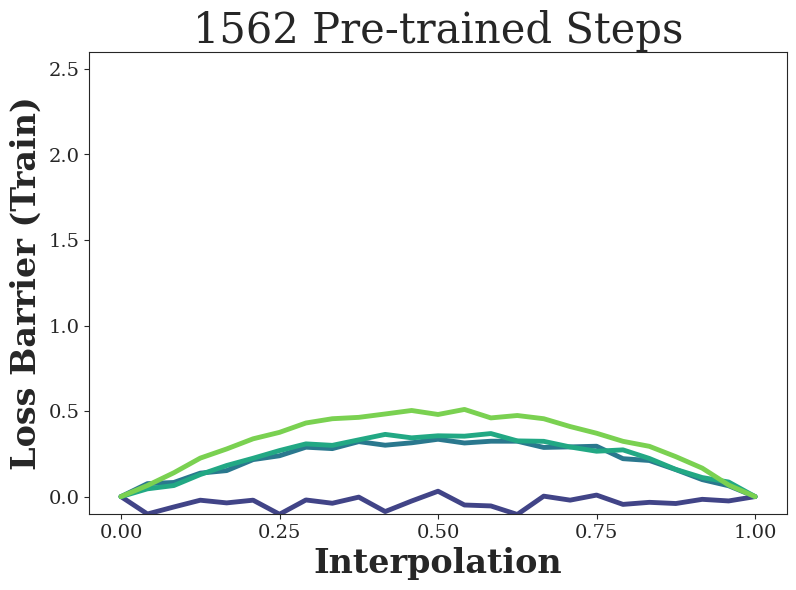

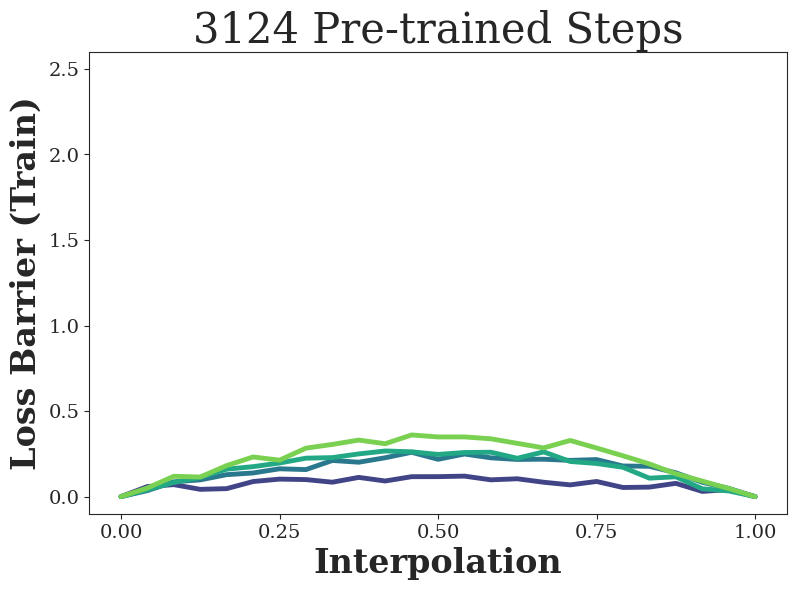

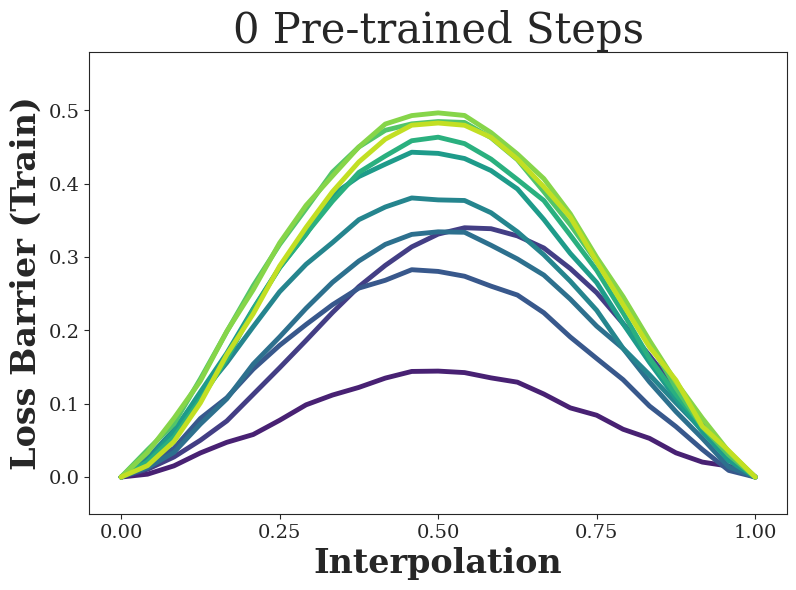

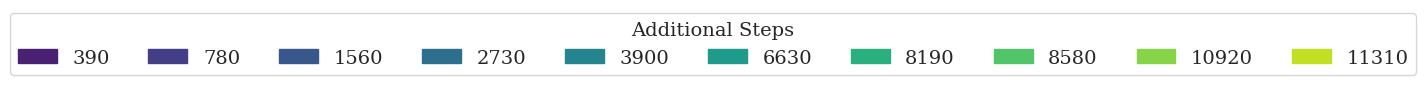

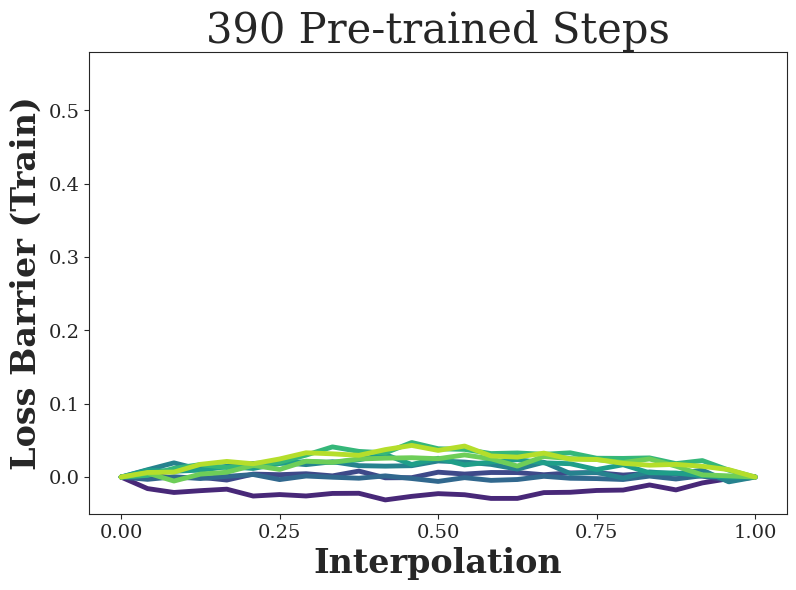

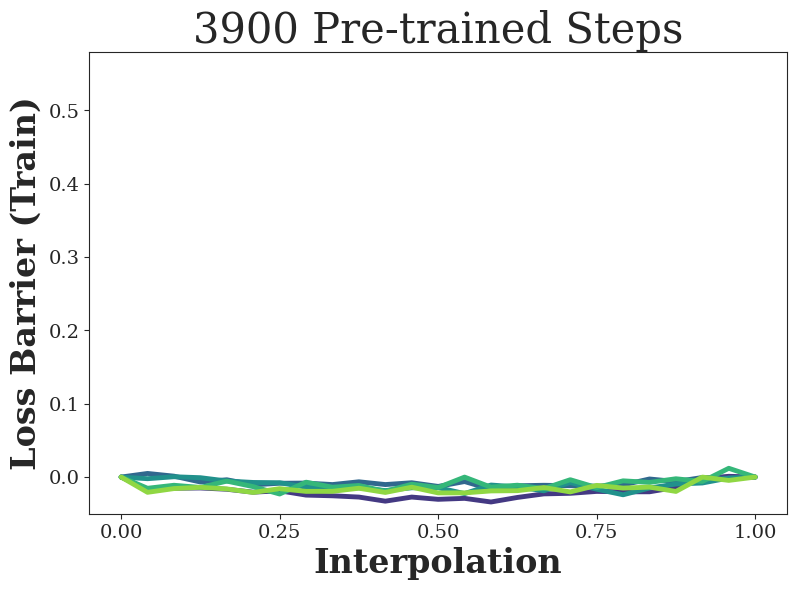

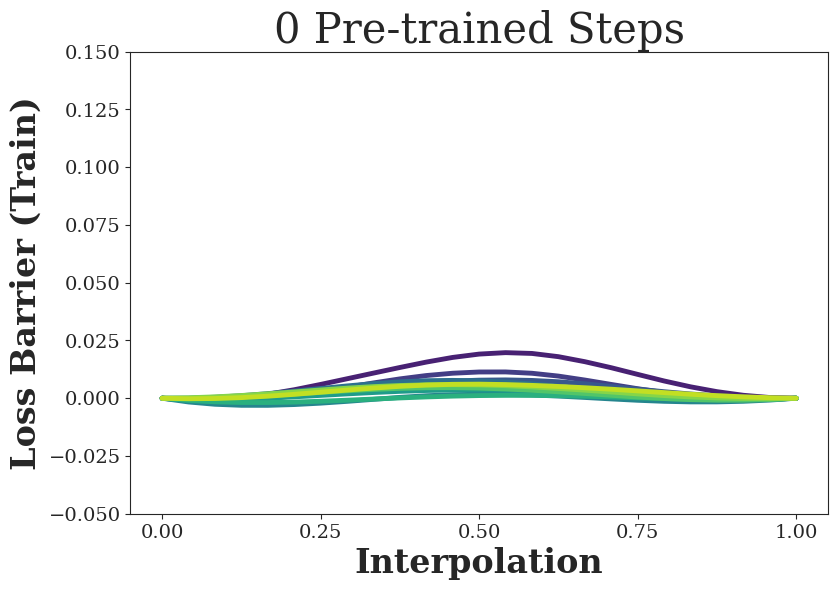

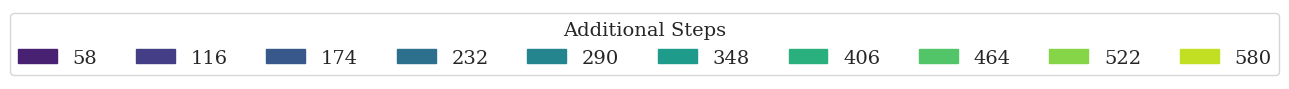

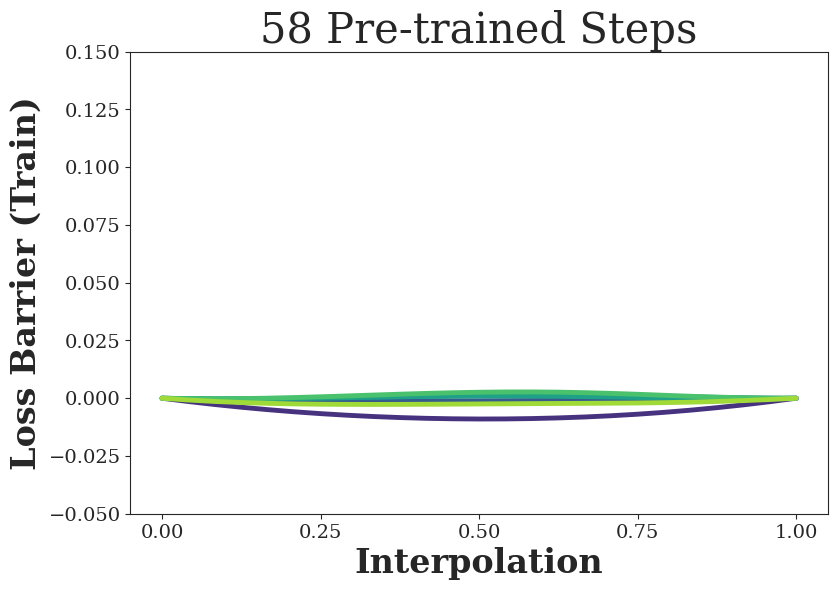

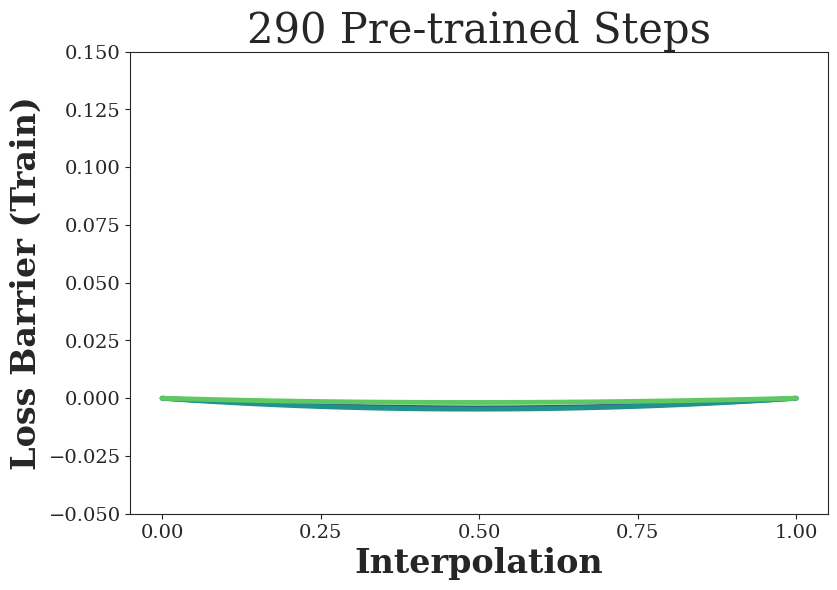

In [47]:
import matplotlib.patches as mpatches
y = "norm_loss_train"

def create_single_plot(df, title, k1_value, filename, y_min, y_max):
    unique_additional_steps = sorted(df['additional_steps'].unique())
    
    filter_down = [3124, 5070,5460,6240,1663, 1170,1950,3510,7410,9750]
    L = [step for step in df[df["k1"] == k1_value]["additional_steps"].unique() if step not in filter_down]
    num = len(L)
    palette = sns.color_palette("viridis", n_colors=num)

    fig, ax = plt.subplots(figsize=(9, 6))

    # Iterate over each additional step and plot the corresponding curve
    counter = 0
    legend_patches = []
    for idx, additional_step in enumerate(unique_additional_steps):
        if additional_step in [3124, 5070,5460,6240,1663, 1170,1950,3510,7410,9750]: continue
        filtered_data = df[(df['k1'] == k1_value) & (df['additional_steps'] == additional_step)]

        if not filtered_data.empty:
            row = filtered_data.iloc[0]
            norm_loss_train = row[y]
            alphas = np.linspace(0, 1, 25)

            line = sns.lineplot(x=alphas, y=norm_loss_train, ax=ax,  color=palette[counter])

            legend_patches.append(mpatches.Patch(color=palette[counter], label=f"{additional_step}"))
            counter += 1

    ax.set_title(f'{k1_value} Pre-trained Steps', fontsize = 30)
    ax.set_xlabel('Interpolation', fontsize=24)
    ax.set_ylabel('Loss Barrier (Train)', fontsize=24)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_ylim(y_min, y_max)
    plt.savefig(f"./plots/linear_path/{filename}.pdf")
    plt.show()
    plt.close(fig)
    

    return legend_patches


def create_legend_plot(legend_patches, title):
    fig, ax = plt.subplots(figsize=(11, 1))
    if len(legend_patches) > 10:
      print()
    ax.legend(handles=legend_patches, loc='center', title='Additional Steps', ncol=len(legend_patches), fontsize=tick_fontsize, title_fontsize=tick_fontsize)
    ax.axis('off')
    fig.tight_layout()
    plt.savefig(f"./plots/linear_path/legend_{title}.pdf")
    plt.show()
    plt.close(fig)

dfs = [df_tinyimagenet,  df_cifar, df_mnist]
titles = ['Tiny-ImageNet', 'CIFAR-10',  'MNIST']
k1_values = {"Tiny-ImageNet": [0, 1562, 3124], "CIFAR-10": [0, 390, 3900],  "MNIST": [0, 58, 290]}

all_legend_patches = []
for j, df in enumerate(dfs):
    y_max, y_min = 2.5, -0.1
    if "CIF" in titles[j]: y_max, y_min = 0.48, -0.05
    if "MNIST" in titles[j]: y_max, y_min = 0.05, -0.05

    for i, k1_value in enumerate(k1_values[titles[j]]):
        filename = f"plot_{j}_{i}_{titles[j].replace('-', '_')}"
        legend_patches = create_single_plot(df, titles[j], k1_value, filename, y_min, y_max+0.1)
        if i == 0:
          create_legend_plot(legend_patches, titles[j])
          all_legend_patches.extend(legend_patches)

unique_legend_patches = list(dict.fromkeys(all_legend_patches))


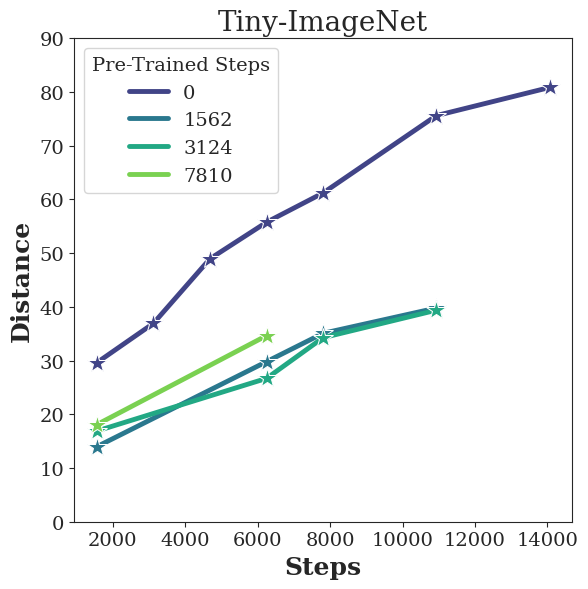

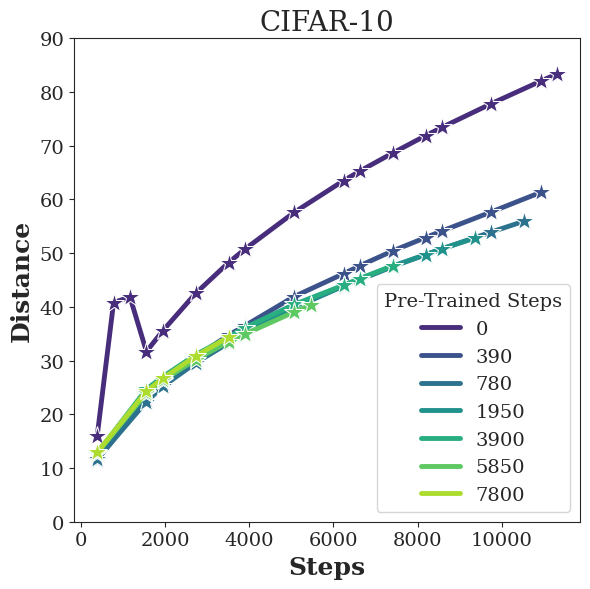

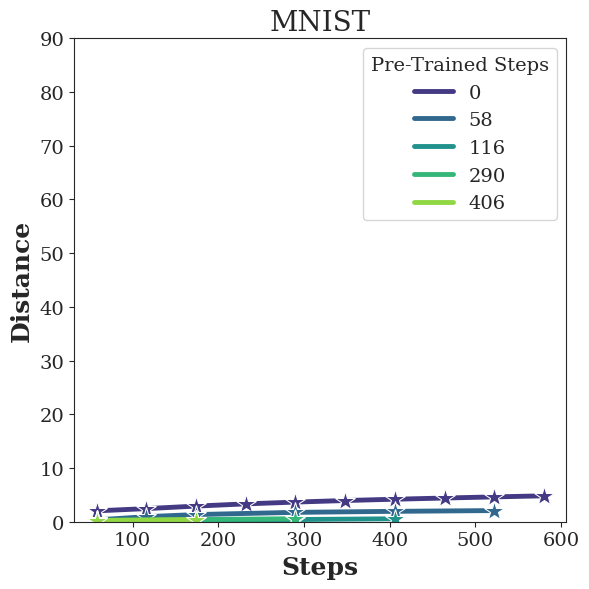

In [14]:
# Create the directory if it doesn't exist
if not os.path.exists("./plots/distance_steps/"):
    os.makedirs("./plots/distance_steps/")

# Calculate the global minimum and maximum values for the y-axis
global_min = 0
global_max = 90

# Iterate over datasets (Tiny-ImageNet, CIFAR-10, and MNIST)
for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(6, 6))

    k1_values = df["k1"].unique()
    palette = sns.color_palette("viridis", n_colors=len(k1_values))

    sns.lineplot(data=df[df["k1"].isin(k1_values)], x='additional_steps', y='distance', marker='*', hue="k1", palette=palette, ax=ax)

    ax.set_xlabel('Steps', fontsize=label_fontsize)
    ax.set_ylabel('Distance', fontsize=label_fontsize)
    ax.set_title(f'{titles[i]}', fontsize=title_fontsize)
    ax.legend(title='Pre-Trained Steps', fontsize=tick_fontsize, title_fontsize=tick_fontsize)

    # Set the same y-axis range for each plot
    ax.set_ylim(global_min, global_max)

    # Adjust layout and spacing
    fig.tight_layout()

    # Save the plot as a PDF
    plt.savefig(f"./plots/distance_steps/{titles[i].replace('-', '_')}.pdf")
    plt.show()
    plt.close(fig)


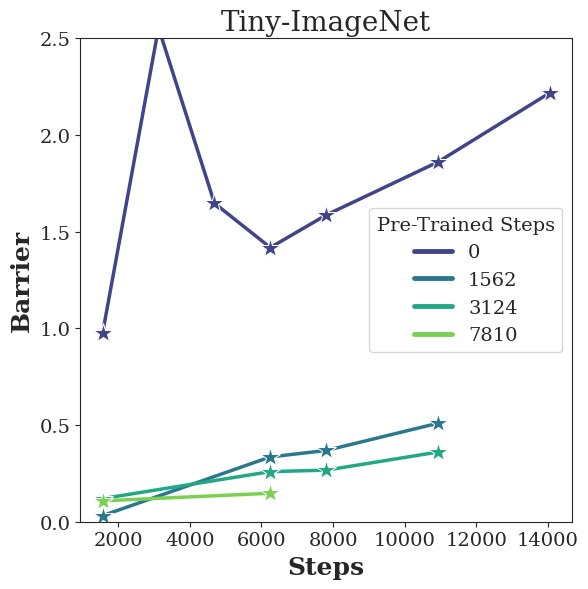

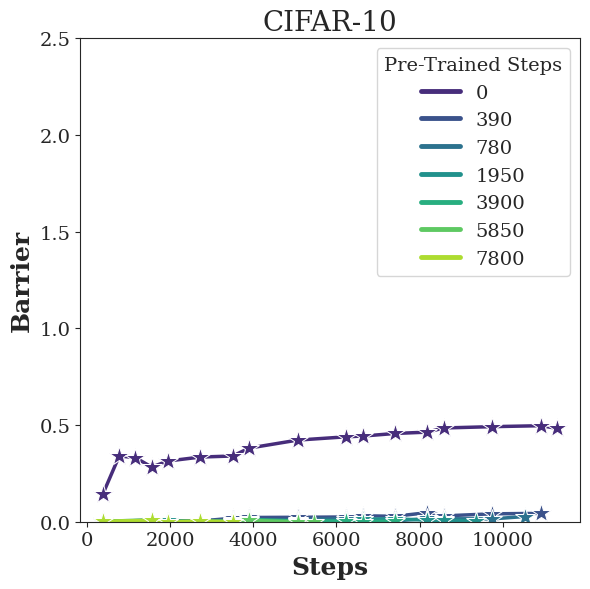

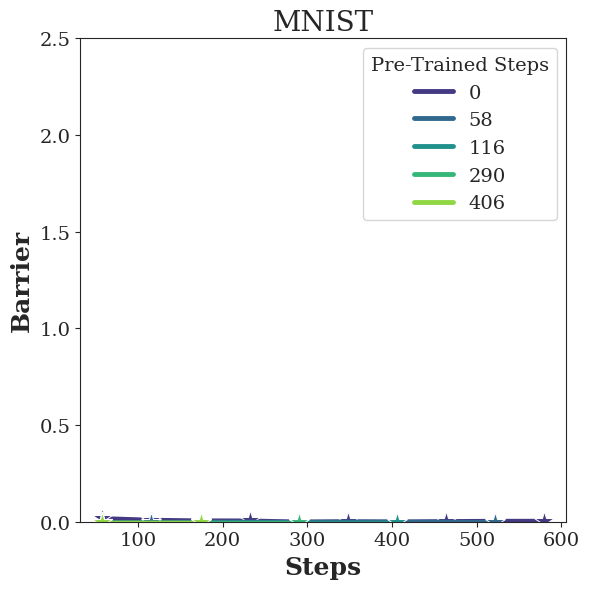

In [49]:


# Calculate the global minimum and maximum values for the y-axis
global_min = 0
global_max = 2.5

# Iterate over datasets (Tiny-ImageNet, CIFAR-10, and MNIST)
for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(6, 6))

    k1_values = df["k1"].unique()
    palette = sns.color_palette("viridis", n_colors=len(k1_values))

    sns.lineplot(data=df[df["k1"].isin(k1_values)], x='additional_steps', y='norm_loss_barrier_train', marker='*', markersize=15, linewidth=2.5, hue="k1", palette=palette, ax=ax)

    ax.set_xlabel('Steps', fontsize=label_fontsize)
    ax.set_ylabel('Barrier', fontsize=label_fontsize)
    ax.set_title(f'{titles[i]}', fontsize=title_fontsize)
    ax.legend(title='Pre-Trained Steps', fontsize=tick_fontsize, title_fontsize=tick_fontsize)

    # Set the same y-axis range for each plot
    ax.set_ylim(global_min, global_max)

    # Adjust layout and spacing
    fig.tight_layout()

    # Save the plot as a PDF
    plt.savefig(f"./plots/distance_steps/barrier_{titles[i].replace('-', '_')}.pdf")
    plt.show()
    plt.close(fig)


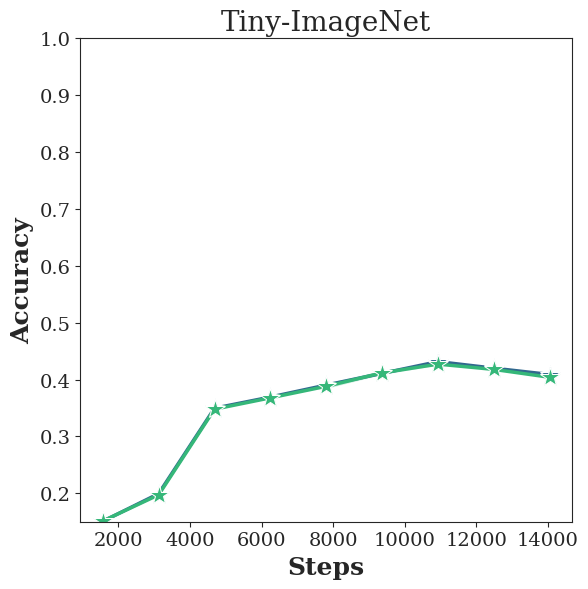

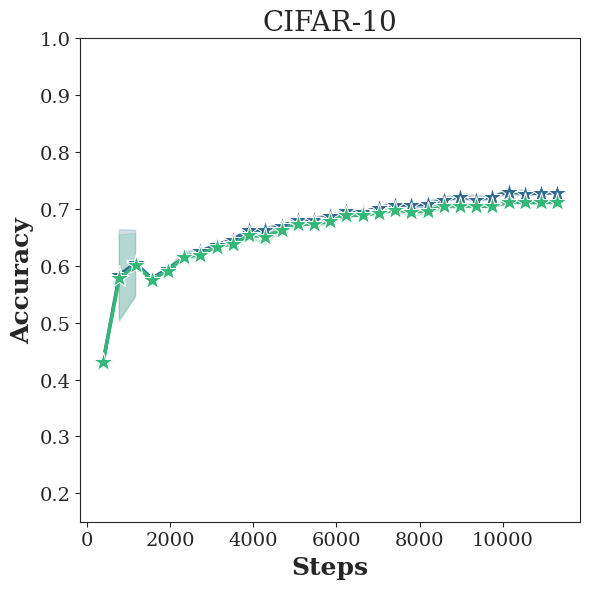

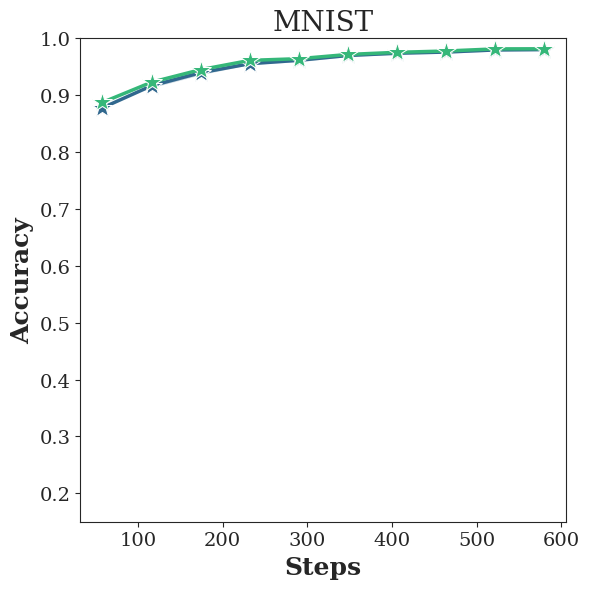

In [10]:
# Iterate over datasets (Tiny-ImageNet, CIFAR-10, and MNIST)
# Create the directory if it doesn't exist
if not os.path.exists("./plots/total_accuracy/"):
    os.makedirs("./plots/total_accuracy/")


import matplotlib.patches as mpatches






palette = sns.color_palette("viridis", n_colors=2)

for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(6, 6))

    sns.lineplot(data=df, x='k2', y=1-df['first_error_train'], marker='*', markersize=15, linewidth=2.5, color=palette[0], ax=ax)
    sns.lineplot(data=df, x='k2', y=1-df['first_error_test'], marker='*', markersize=15, linewidth=2.5, color=palette[1], ax=ax)

    ax.set_xlabel('Steps', fontsize=label_fontsize)
    ax.set_ylabel('Accuracy', fontsize=label_fontsize)
    ax.set_title(f'{titles[i]}', fontsize=title_fontsize)

    # Set the same y-axis range for each plot
    ax.set_ylim(0.15, 1)

    # Adjust layout and spacing
    fig.tight_layout()
    # Create and store legend patches only once
    if i == 0:
        legend_patches = [
            mpatches.Patch(color=palette[0], label="Train"),
            mpatches.Patch(color=palette[1], label="Test"),
        ]

# Save the legend separately as a PDF

    # Save the plot as a PDF
    plt.savefig(f"./plots/total_accuracy/{titles[i].replace('-', '_')}.pdf")
    plt.show()
    plt.close(fig)

## Plots for the Appendix 

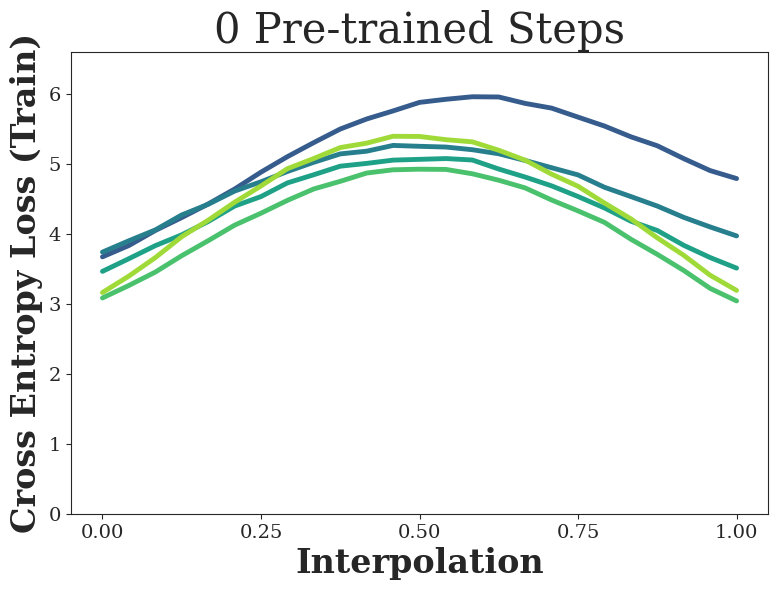

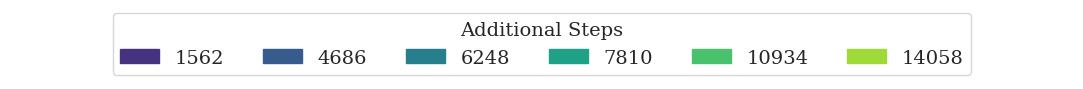

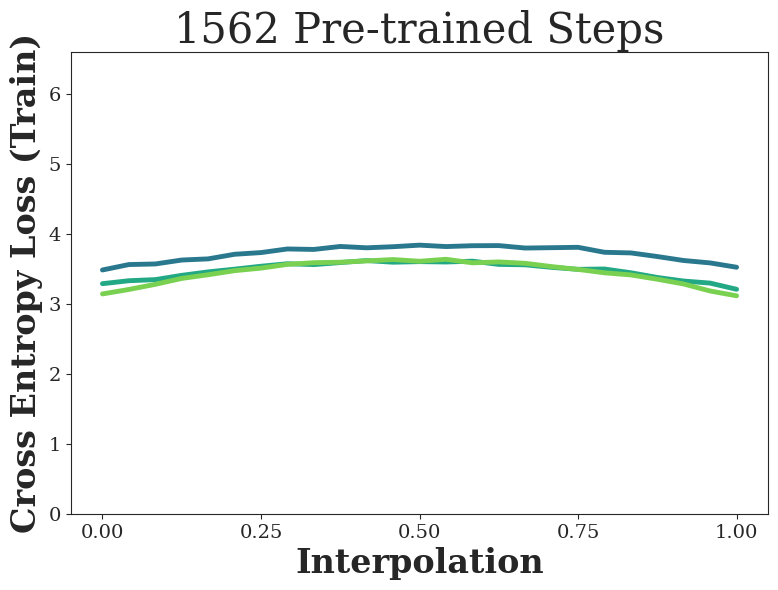

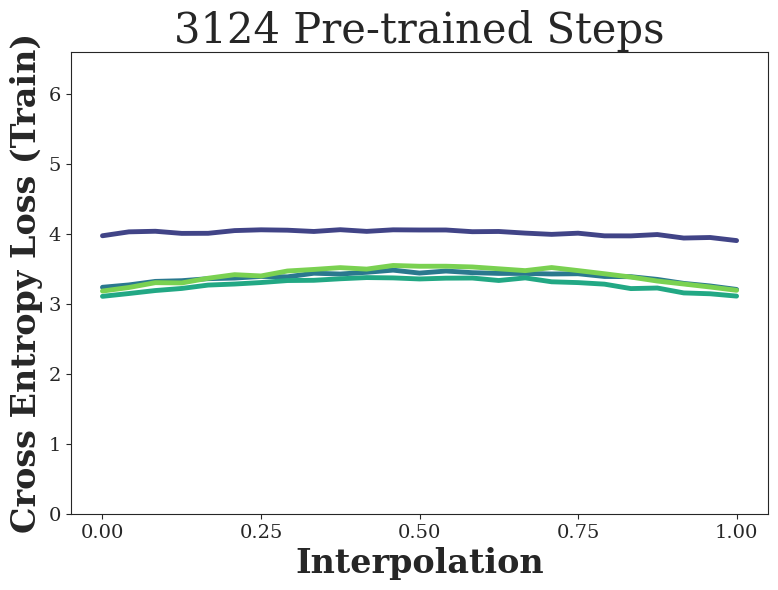

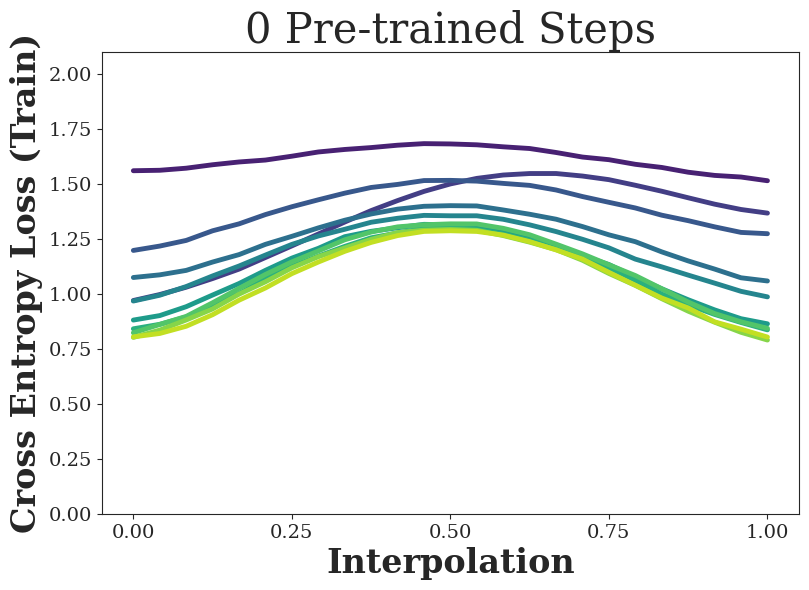

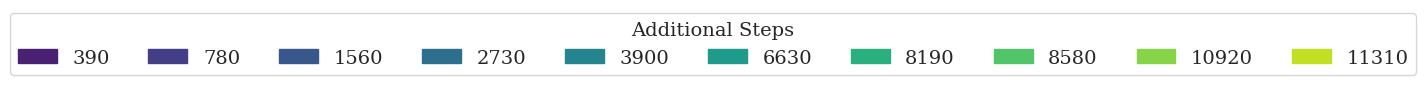

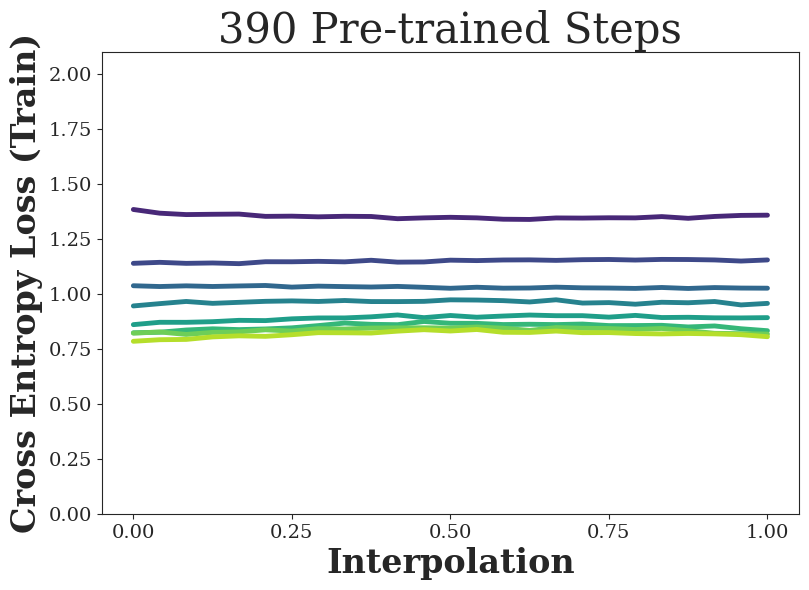

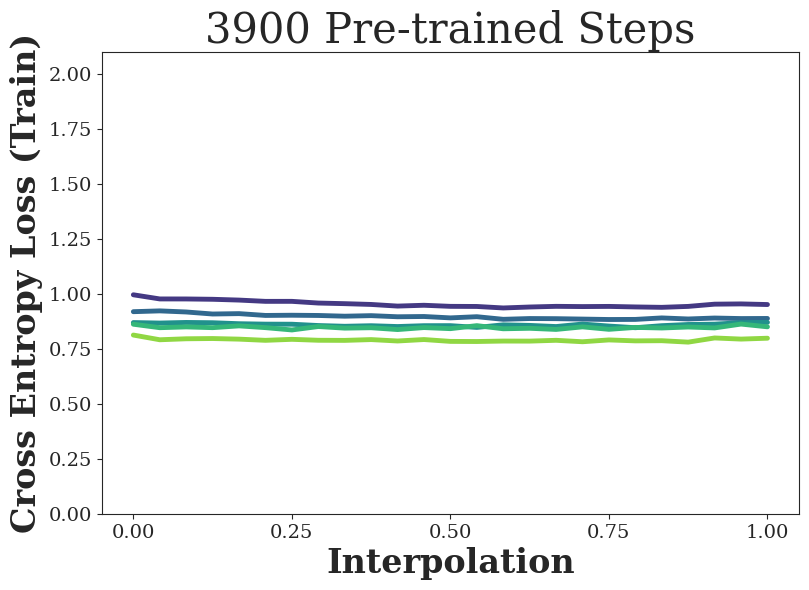

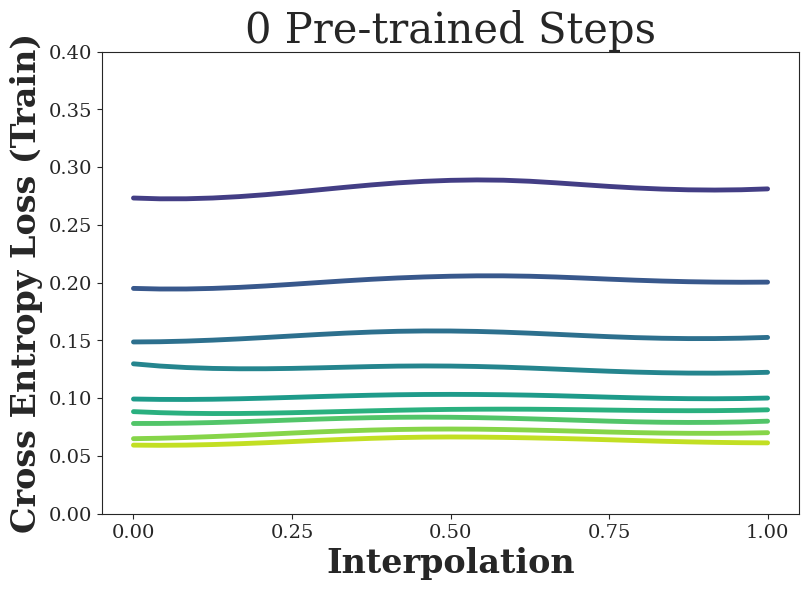

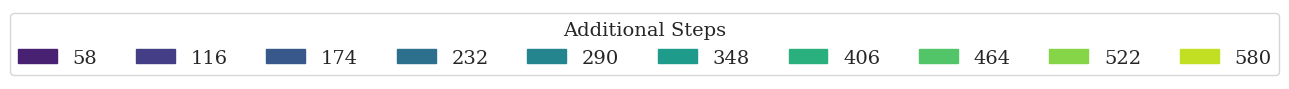

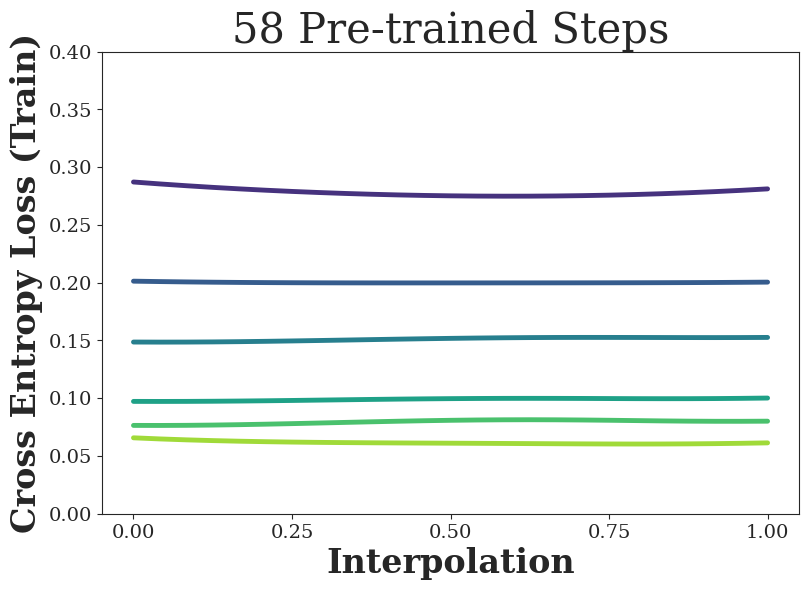

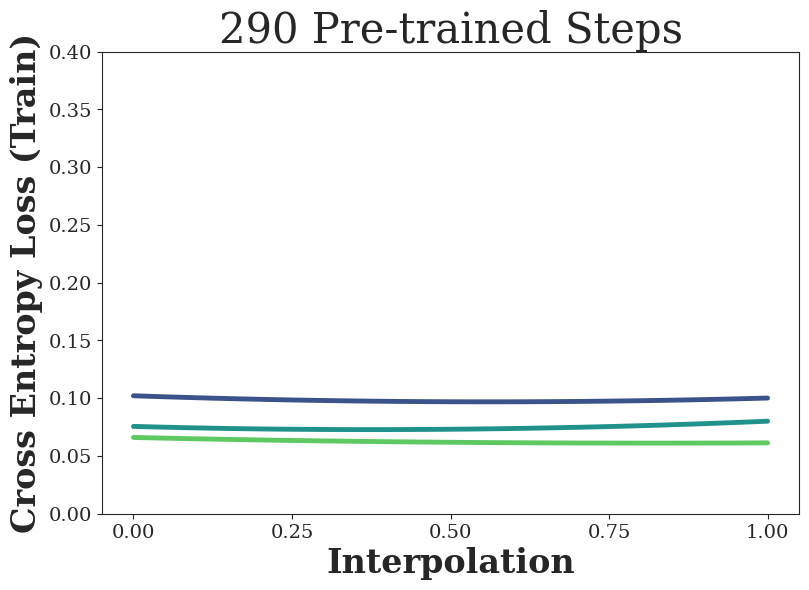

In [20]:
if not os.path.exists("./plots/appendix/"):
    os.makedirs("./plots/appendix/")

y = "losses_train"

def create_single_plot(df, title, k1_value, filename, y_min, y_max):
    unique_additional_steps = sorted(df['additional_steps'].unique())
    
    filter_down = [3124, 5070,5460,6240,1663, 1170,1950,3510,7410,9750]
    L = [step for step in df[df["k1"] == k1_value]["additional_steps"].unique() if step not in filter_down]
    num = len(L)
    palette = sns.color_palette("viridis", n_colors=num)

    fig, ax = plt.subplots(figsize=(9, 6))

    # Iterate over each additional step and plot the corresponding curve
    counter = 0
    legend_patches = []
    for idx, additional_step in enumerate(unique_additional_steps):
        if additional_step in [3124, 5070,5460,6240,1663, 1170,1950,3510,7410,9750]: continue
        filtered_data = df[(df['k1'] == k1_value) & (df['additional_steps'] == additional_step)]

        if not filtered_data.empty:
            row = filtered_data.iloc[0]
            norm_loss_train = row[y]
            alphas = np.linspace(0, 1, 25)

            line = sns.lineplot(x=alphas, y=norm_loss_train, ax=ax,  color=palette[counter])

            legend_patches.append(mpatches.Patch(color=palette[counter], label=f"{additional_step}"))
            counter += 1

    ax.set_title(f'{k1_value} Pre-trained Steps', fontsize = 30)
    ax.set_xlabel('Interpolation', fontsize=24)
    ax.set_ylabel('Cross Entropy Loss (Train)', fontsize=24)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_ylim(y_min, y_max)
    plt.savefig(f"./plots/appendix/loss_{filename}.pdf")
    plt.show()
    plt.close(fig)
    

    return legend_patches


def create_legend_plot(legend_patches, title):
    fig, ax = plt.subplots(figsize=(11, 1))
    if len(legend_patches) > 10:
      print()
    ax.legend(handles=legend_patches, loc='center', title='Additional Steps', ncol=len(legend_patches), fontsize=tick_fontsize, title_fontsize=tick_fontsize)
    ax.axis('off')
    fig.tight_layout()
    plt.savefig(f"./plots/appendix/legend_{title}.pdf")
    plt.show()
    plt.close(fig)

dfs = [df_tinyimagenet,  df_cifar, df_mnist]
titles = ['Tiny-ImageNet', 'CIFAR-10',  'MNIST']
k1_values = {"Tiny-ImageNet": [0, 1562, 3124], "CIFAR-10": [0, 390, 3900],  "MNIST": [0, 58, 290]}

all_legend_patches = []
for j, df in enumerate(dfs):
    y_max, y_min = 6.5,0
    if "CIF" in titles[j]: y_max, y_min = 2,0
    if "MNIST" in titles[j]: y_max, y_min = 0.3,0

    for i, k1_value in enumerate(k1_values[titles[j]]):
        filename = f"plot_{j}_{i}_{titles[j].replace('-', '_')}"
        legend_patches = create_single_plot(df, titles[j], k1_value, filename, y_min, y_max+0.1)
        if i == 0:
          create_legend_plot(legend_patches, titles[j])
          all_legend_patches.extend(legend_patches)

unique_legend_patches = list(dict.fromkeys(all_legend_patches))
